In [ ]:
# The aim of this code is to compare an equally weighted portfolio and optimize the weights to obtain 
# the best allocation of the portfolio maximizing returns for the minimum volatility. 

In [1]:
import pandas as pd
pd.core.common.is_list_like = pd.api.types.is_list_like
import matplotlib.pyplot as plt
import numpy as np
import yfinance as yf


In [2]:
assets = ['AAPL', 'GM', 'GE', 'FB', 'WMT'] 

In [3]:
start_date = "2015-01-01"
end_date = "2020-01-10"

In [30]:
df1= yf.download(assets, start=start_date, end = end_date)['Adj Close']

[*********************100%***********************]  5 of 5 completed


In [4]:
df=pd.DataFrame()
for asset in assets:
    df_asset = yf.download(asset, start=start_date, end=end_date)["Adj Close"]
    df_asset = df_asset.to_frame(name=asset)
    df = pd.concat([df_asset, df], axis=1, sort=False)
df = df.dropna()
df.head(5)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,WMT,FB,GE,GM,AAPL
Date,,,,,
2014-12-31,75.782684,78.019997,20.899740,27.987682,101.419060
2015-01-02,75.800331,78.449997,20.726057,27.931570,100.454300
2015-01-05,75.579727,77.190002,20.345612,27.522697,97.624336
2015-01-06,76.162109,76.150002,19.907272,27.939589,97.633545
2015-01-07,78.182854,76.150002,19.915545,28.733286,99.002556


In [ ]:
df.tail()

In [ ]:
df1.head()

In [ ]:
df.var()

In [ ]:
df.std() # Standard deviation before percentatge changes, why it changes? 

In [ ]:
df.info()

In [ ]:
normalized_df1 = df1.div(df1.iloc[0]).mul(100) #here I normalize the prices to compare performance graphically
normalized_df1

In [ ]:
normalized_df1.std() # Why is different with the prices volatility?

In [ ]:
# Here I inspect & compare graphically the ETF's evolution
plt.style.use('seaborn')
normalized_df1.plot(figsize = (15, 8 ), fontsize = 13)
plt.legend(fontsize = 13)
plt.show()

In [32]:
df = df.pct_change().dropna() 

#Creamos matriz de pesos para cada activo ("Equally weighted")

weights = [0.6 , 0.1 , 0.1 , 0.1 , 0.1]   #empty list

n_assets = len(assets) 

#Equally weighted portfolio
#for i in range(n_assets):
    #weights.append(1/n_assets)

w = np.array(weights)

In [33]:
w

array([0.6, 0.1, 0.1, 0.1, 0.1])

In [34]:
df.head()

,WMT,FB,GE,GM,AAPL
Date,,,,,
2015-01-02,0.000233,0.005511,-0.008310,-0.002005,-0.009513
2015-01-05,-0.002910,-0.016061,-0.018356,-0.014638,-0.028172
2015-01-06,0.007706,-0.013473,-0.021545,0.015147,0.000094
2015-01-07,0.026532,0.000000,0.000416,0.028408,0.014022
2015-01-08,0.021106,0.026658,0.012043,0.010044,0.038422


In [35]:
r = np.array(np.mean(df))   
C = np.cov(df.transpose()) #Estimate a covariance matrix, given data and weights.

#Validamos
print("Rendimiento esperado:", r)
print("Pesos activos:", w)
print("Matriz VarCov:", C)

Rendimiento esperado: [ 0.00042175  0.00097294 -0.00026797  0.00030973  0.00100586]
Pesos activos: [0.6 0.1 0.1 0.1 0.1]
Matriz VarCov: [[1.51614556e-04 3.44783874e-05 3.47084707e-05 3.98031827e-05
  4.50514617e-05]
 [3.44783874e-05 3.15105000e-04 7.81661293e-05 8.87496057e-05
  1.28060900e-04]
 [3.47084707e-05 7.81661293e-05 3.55275958e-04 1.00442237e-04
  8.15190524e-05]
 [3.98031827e-05 8.87496057e-05 1.00442237e-04 2.63541456e-04
  8.48716806e-05]
 [4.50514617e-05 1.28060900e-04 8.15190524e-05 8.48716806e-05
  2.44567994e-04]]


In [36]:
def mu(w,r):
    '''Rendimiento portafolio anualizado'''
    return sum(w * r * 252) 


def sigma(w, C):
    '''Desv STD portadolio anualizada'''
    return np.dot(w,np.dot(C,w.T)) ** (1/2) * 252 ** (1/2)


def sharpe(w):
    '''Sharpe ratio con rf de 4%'''
    rf = .04
    return (mu(w,r) - rf) / sigma(w,C)


def neg_sharpe(w):
    '''Sharpe ratio negativo'''
    return -sharpe(w)


def random_ports(n):
    '''Portafolio aleatorios'''
    means, stds = [],[]
    for i in range(n):
        rand_w = np.random.rand(len(assets))
        rand_w = rand_w / sum(rand_w)
        means.append(mu(rand_w, r))
        stds.append(sigma(rand_w,C))
    
    return means, stds

In [37]:
results_equal_portfolio = [('Return = ', mu(w,r)), ('Desviation = ' ,sigma(w,C)), ('Sharpe = ', sharpe(w))]
results_equal_portfolio

[('Return = ', 0.11468669295852546),
 ('Desviation = ', 0.15560849512285652),
 ('Sharpe = ', 0.47996539584524983)]

In [ ]:
# Pero lo interesante, es calcular los pesos que mejor Sharpe ratio puedan lograr con esta 
# combinación de activos, esto es un problema de optimización que en Excel se resuelve con Solver, 
# para este caso usaremos scipy. Definiendo que ninguna variable puede ser negativa con un valor 
# máximo de 1 y que la suma de las variable debe ser igual a 1, así:

In [38]:
import scipy.optimize as optimize

In [39]:
def apply_sum_constraint(inputs):
    total = 1 - np.sum(inputs)
    return total

my_constraints = ({'type': 'eq', "fun": apply_sum_constraint })
bounds = ((0,1.0),)*n_assets


result = optimize.minimize(neg_sharpe, 
                      w, 
                      method='SLSQP', #difeferent methods avaiable
                      bounds= bounds,#((0, 1.0), (0, 1.0), (0, 1.0),(0,1.0)), #define the min and max weight for each asset
                      options={'disp': True},
                      constraints=my_constraints)
print(result)
optimal_w = result["x"]

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -0.9452548088900838
            Iterations: 7
            Function evaluations: 49
            Gradient evaluations: 7
     fun: -0.9452548088900838
     jac: array([-0.19803163, -0.19805428,  0.76721625,  0.08057056, -0.1980719 ])
 message: 'Optimization terminated successfully.'
    nfev: 49
     nit: 7
    njev: 7
  status: 0
 success: True
       x: array([1.35707886e-01, 3.13296477e-01, 7.88214979e-17, 0.00000000e+00,
       5.50995637e-01])


Text(0.5, 1.0, 'Mean and standard deviation of returns of randomly generated portfolios')

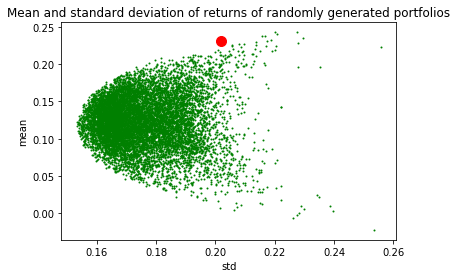

In [40]:
#Grafiquemos
n_portfolios = 10000
means, stds = random_ports(n_portfolios)

best_mu = mu(optimal_w, r)
best_sigma = sigma(optimal_w, C)
best_sharpe = sharpe(optimal_w)
plt.plot(stds, means, 'o',color='g', markersize=1)
plt.plot(best_sigma, best_mu, 'o', color='red' , markersize=10)
plt.xlabel('std')
plt.ylabel('mean')
plt.title('Mean and standard deviation of returns of randomly generated portfolios')


In [41]:
results_best_portfolio = [('Return = ', mu(optimal_w,r)), ('Desviation = ' ,sigma(optimal_w,C)), ('Sharpe = ', sharpe(optimal_w))]
results_best_portfolio

[('Return = ', 0.230901833061297),
 ('Desviation = ', 0.20195806597953572),
 ('Sharpe = ', 0.9452548088900838)]

In [ ]:
#A good way to estimate future returns is to fit an ARMA model 
# conditional mean return are time varying while unconditional are the average statit return
# at the same time, we are interested in conditional variance that we can modelate time-varying variance with 
#GARCH models